# Промышленность

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургического комбината «Стальная птица» требуется уменьшить потребление электроэнергии на этапе обработки стали. Для этого требуется контролировать температуру сплава.

Задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from pathlib import Path
from sqlalchemy import create_engine, text

In [21]:
# Определим переменные
RANDOM_STATE = 190923
# папка для хранения временных данных
TMP='./cache'
# Использование данных из кэша
USE_CACHE=False

In [22]:
# создаём временный каталог для хранения данных
Path(TMP).mkdir(parents=True, exist_ok=True)

In [23]:
# проверка кэша
onlyfiles = [f for f in listdir(TMP) if isfile(join(TMP, f))]

onlyfiles

['steel.data_arc.csv',
 'steel.data_bulk.csv',
 'steel.data_bulk_time.csv',
 'steel.data_gas.csv',
 'steel.data_temp.csv',
 'steel.data_wire.csv',
 'steel.data_wire_time.csv']

In [24]:
USE_CACHE = len(onlyfiles) > 0

## Подключение к базе данных

In [25]:
db_config = {
    'user': 'praktikum_student',# имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',# пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения
    'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)
conn = engine.connect()

In [26]:
query = text('''
SELECT * FROM information_schema.tables AS t
WHERE t.table_schema = 'steel';
''')

tables_df = pd.read_sql_query(query, conn)

tables_df

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,data-science-final,steel,data_arc,BASE TABLE,None,None,None,None,None,YES,NO,None
1,data-science-final,steel,data_bulk,BASE TABLE,None,None,None,None,None,YES,NO,None
2,data-science-final,steel,data_bulk_time,BASE TABLE,None,None,None,None,None,YES,NO,None
3,data-science-final,steel,data_gas,BASE TABLE,None,None,None,None,None,YES,NO,None
4,data-science-final,steel,data_temp,BASE TABLE,None,None,None,None,None,YES,NO,None
5,data-science-final,steel,data_wire,BASE TABLE,None,None,None,None,None,YES,NO,None
6,data-science-final,steel,data_wire_time,BASE TABLE,None,None,None,None,None,YES,NO,None


### Описание данных

База данных состоит из нескольких таблиц:
* steel.data_arc — данные об электродах;
* steel.data_bulk — данные об объёме сыпучих материалов;
* steel.data_bulk_time — данные о времени подачи сыпучих материалов;
* steel.data_gas — данные о продувке сплава газом;
* steel.data_temp — данные об измерениях температуры;
* steel.data_wire — данные об объёме проволочных материалов;
* steel.data_wire_time — данные о времени подачи проволочных материалов.

__Таблица steel.data_arc__
* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.

__Таблица steel.data_bulk__
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.

__Таблица steel.data_bulk_time__
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.

__Таблица steel.data_gas__
* key — номер партии;
* gas — объём подаваемого газа.

__Таблица steel.data_temp__
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.

__Таблица steel.data_wire__
* key — номер партии;
* Wire1 … Wire15 — объём подаваемых проволочных материалов.

__Таблица steel.data_wire_time__
* key — номер партии;
* Wire1 … Wire15 — время подачи проволочных материалов.

Во всех таблицах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Первичное исследование таблиц

Чтобы не загружать базу данных запросами, сохраним информацию в "локальном кэше"

In [27]:
# создадим вспомогательные функции

def query_fast(query):
    """
    Быстрое выполнение запроса
    
    Параметры:
    ----------
    query: text - запрос
    """
    return pd.read_sql_query(text(query), conn)

def query_info(query, limit=5):
    """
    Получение простой информации по запросу
    
    Параметры:
    ----------
    query: text - запрос
    where: text - условие
    limit: integer - количество записей для вывода
    """
    table_query = text(f'{query} LIMIT {limit};')
    table_df = pd.read_sql_query(table_query, conn)
    display(table_df)
    
    table_count_query = text(f'{query.replace("*", "COUNT(*)")};')
    table_count_df = pd.read_sql_query(table_count_query, conn)
    print(f"Общее количество записей: {table_count_df.loc[0, 'count']}")

In [28]:
# проверим все талбицы на наличие данных и сохраним результаты в локальное хранилище
tables = [
    'steel.data_arc', 
    'steel.data_bulk', 
    'steel.data_bulk_time', 
    'steel.data_gas', 
    'steel.data_temp', 
    'steel.data_wire', 
    'steel.data_wire_time'
]

if not USE_CACHE:
    for table in tables:
        query_info(f'SELECT * FROM {table}')
    
    # Так как количество данных в таблицах не столь велико, то сохраним данные в кэше
    for table in tables:
        query_fast(f'SELECT * FROM {table}').to_csv(TMP + f'/{table}.csv', index=False)
    
    USE_CACHE = True
else:
    print('Данные будут получены из локального кэша')

Данные будут получены из локального кэша


#### Данные об электродах

In [29]:
data_arc = pd.read_csv(TMP + '/steel.data_arc.csv')

data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S').dt.time
data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S').dt.time

display(data_arc.head())

print()

data_arc.info()

print()

data_arc.describe()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB



,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


___Примечание___: после анализа колонок `ReactivePower` выявлено аномальное минимальное значение, изучим подробнее.

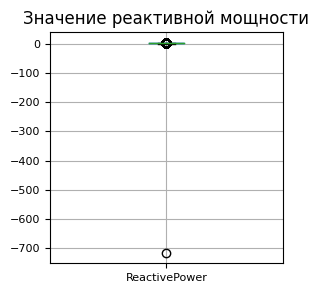

In [30]:
data_arc.boxplot(column=['ReactivePower'], figsize=(3, 3), fontsize=8)
plt.title('Значение реактивной мощности')
plt.show()

In [31]:
condition = data_arc['ReactivePower'] < -600
data_arc[condition]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9781,2116,00:44:48,00:46:37,0.495782,-715.504924


In [32]:
# заменим аномальный всплеск средним значением
data_arc.loc[condition, 'ReactivePower'] = data_arc['ReactivePower'].mean()

Сгененрируем фичи

In [33]:
def total_seconds(x):
    """
    Вспомогательная функция для подсчёта секунд
    
    Параметры:
    ----------
    x: datetime.time
    
    Результат:
    ----------
    int - общее количество секунд
    """

    return (x.hour * 3600) + (x.minute * 60) + x.second

def diff_seconds(row):
    """
    Вспомогательная функция для подсчёта разницы в секундах
    
    Параметры:
    ----------
    row: Serias
    
    Результат:
    int - секунды
    """
    if row['EndHeatSeconds'] > row['BeginHeatSeconds']:
        return row['EndHeatSeconds'] - row['BeginHeatSeconds']
    else:
        # таким образом обработаем переход через 0
        return (row['EndHeatSeconds'] + 86400) - row['BeginHeatSeconds']

In [34]:
# переведём временные значения в секунды
data_arc['BeginHeatSeconds'] = data_arc['BeginHeat'].apply(total_seconds)
data_arc['EndHeatSeconds'] = data_arc['EndHeat'].apply(total_seconds)

# генерация новых признаков
data_arc['DeltaHeatSeconds'] = data_arc.apply(diff_seconds, axis=1)

data_arc['TotalPower'] = data_arc['ActivePower'] + data_arc['ReactivePower']
data_arc['RelPower'] = data_arc['ActivePower'] / data_arc['ReactivePower']

In [35]:
# проверим ещё раз распределение
data_arc[['BeginHeatSeconds', 'EndHeatSeconds', 'DeltaHeatSeconds']].describe()

,BeginHeatSeconds,EndHeatSeconds,DeltaHeatSeconds
count,14876.000000,14876.000000,14876.000000
mean,43148.600027,43192.494689,171.670946
std,24998.711157,24996.782760,98.186803
min,1.000000,7.000000,11.000000
25%,21776.750000,21793.750000,107.000000
50%,42775.000000,42832.000000,147.000000
75%,64685.750000,64730.250000,214.000000
max,86375.000000,86398.000000,907.000000


In [36]:
# сагрегируем признаки по номеру партии
data_arc = data_arc.groupby('key').agg({'ActivePower': 'sum', 'ReactivePower': 'sum', 'BeginHeatSeconds': 'min', 'EndHeatSeconds': 'max', 'DeltaHeatSeconds': 'sum', 'TotalPower': 'sum', 'RelPower': 'sum', 'BeginHeat': 'count'})

In [37]:
data_arc = data_arc.rename(columns= {'BeginHeat':'Iteration'})
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ActivePower       3214 non-null   float64
 1   ReactivePower     3214 non-null   float64
 2   BeginHeatSeconds  3214 non-null   int64  
 3   EndHeatSeconds    3214 non-null   int64  
 4   DeltaHeatSeconds  3214 non-null   int64  
 5   TotalPower        3214 non-null   float64
 6   RelPower          3214 non-null   float64
 7   Iteration         3214 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 226.0 KB


В итоге мы получаем следующую таблицу:
* `key` - номер партии;
* `ActivePower` - значение активной мощности;
* `BeginHeatSeconds` - время начала нагрева в секундах;
* `EndHeatSeconds` - время завершения нагрева в секундах;
* `ReactivePower` - значение реактивной мощности;
* `DeltaHeatSeconds` - время нагрува в секундах;
* `TotalPower` - сумма мощностей;
* `RelPower` - соотношение активной мощности к реактивной;
* `Iteration` - количество итераций.

#### Данные об объёме сыпучих материалов

In [456]:
data_bulk = pd.read_csv(TMP + '/steel.data_bulk.csv')

display(data_bulk.head())

print()

data_bulk.info()

print()

data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [457]:
# установим индекс
data_bulk = data_bulk.set_index('key')

In [458]:
# заполним пропуски
data_bulk = data_bulk.fillna(0)

#### Данные о времени подачи сыпучих материалов

In [459]:
data_bulk_time = pd.read_csv(TMP + '/steel.data_bulk_time.csv')

display(data_bulk_time.head())

print()

data_bulk_time.info()

print()

data_bulk_time.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:03:52,NaN,11:03:52,11:03:52
1,2,NaN,NaN,NaN,11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:40:20,NaN,11:40:20,11:40:20
2,3,NaN,NaN,NaN,12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:09:40,NaN,12:09:40,12:09:40
3,4,NaN,NaN,NaN,12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:41:24,NaN,12:41:24,12:41:24
4,5,NaN,NaN,NaN,13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:12:56,NaN,13:12:56,13:12:56



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [460]:
# установим индекс
data_bulk_time = data_bulk_time.set_index('key')

In [461]:
cols = data_bulk_time.columns
# приведём переменные Bulk к типу time
for col in cols:
    if col.find('Bulk') >= 0:
        data_bulk_time[f'{col}Time'] = pd.to_datetime(data_bulk_time[col], format='%H:%M:%S').dt.time
        data_bulk_time[f'{col}Time'] = data_bulk_time[f'{col}Time'].apply(total_seconds)

In [383]:
def get_min_value(row):
    """
    Получение минимальной даты
    
    Параметры:
    ----------
    row: Series
    """
    return np.min(row.values, where=~np.isnan(row.values), initial=86400)

def get_max_value(row):
    return np.max(row.values, where=~np.isnan(row.values), initial=0)

In [462]:
colsTime = []
for col in cols:
    colsTime.append(f'{col}Time')

In [463]:
data_bulk_time['MinSecond'] = data_bulk_time[colsTime].apply(get_min_value, axis=1)
data_bulk_time['MaxSecond'] = data_bulk_time[colsTime].apply(get_max_value, axis=1)

In [464]:
data_bulk_time['DiffSecond'] = data_bulk_time['MaxSecond'] - data_bulk_time['MinSecond']

<AxesSubplot:>

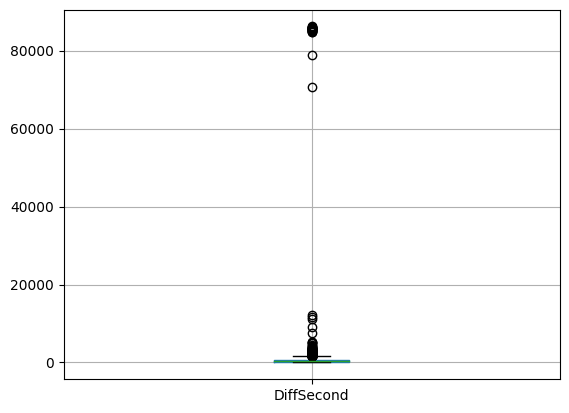

In [465]:
data_bulk_time.boxplot('DiffSecond')

In [467]:
data_bulk_time.loc[data_bulk_time['DiffSecond'] > 20000, cols]

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
44,NaN,NaN,NaN,NaN,NaN,22:33:48,NaN,NaN,NaN,NaN,NaN,00:39:35,00:39:35,22:15:42,00:39:35
74,NaN,NaN,NaN,00:01:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:53:27,NaN,23:53:27,23:53:27
126,NaN,NaN,00:00:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:46:55,NaN,23:46:55,23:46:55
232,NaN,NaN,NaN,NaN,00:01:33,NaN,NaN,NaN,NaN,NaN,NaN,23:50:13,NaN,23:50:13,23:50:13
280,NaN,NaN,23:51:46,NaN,NaN,NaN,NaN,NaN,00:04:56,NaN,NaN,23:23:23,NaN,23:23:23,NaN
641,NaN,NaN,NaN,01:03:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20:42:03,20:42:03,NaN,20:42:03
642,NaN,NaN,NaN,00:22:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:56:15,NaN,23:56:15,23:56:15
913,NaN,NaN,00:12:43,NaN,NaN,00:12:43,NaN,NaN,NaN,NaN,NaN,23:57:38,NaN,23:57:38,NaN
999,NaN,NaN,00:04:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:56:29,NaN,23:56:29,23:56:29


In [236]:
# закрываем соединение
engine.dispose()